# This file produces 

| Filename / Object             | Format (on disk)            | Key Columns / Schema                                                                                                                                                   | Source / Derivation                                                                                                                                               | Role / Use in Analysis                                                                                                          |
| ----------------------------- | --------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| `crsp_treasury_panel.parquet` | Parquet (binary, columnar)  | Includes columns: `crspid, qdate, bid, ask, source, accint, yield, retnua, duratn, cusip, matdt, datdt, totout, pubout, plus derived fields mid_price, bid_ask_spread` | Built by merging CRSP tables: `bmquotes`, `bmyield`, `bmheader`, `bmdebt` from your WRDS CRSP “crsp_a_treasuries / crsp” libraries                                | The core issue-level daily panel used to build liquidity metrics, link to synthetic arbitrage, regressions, feature engineering |
| `crsp_treasury_agg.csv`       | CSV (comma separated, text) | `qdate`, `bid_ask_spread` (mean), `pubout` (sum), `n_issues` (count of issues)                                                                                         | Aggregated from `crsp_treasury_panel.parquet` by grouping by date                                                                                                 | A marketwide daily time-series snapshot (liquidity and supply) for control variables and macro alignment                        |
| `tenor_liq.parquet`           | Parquet                     | `qdate`, `tenor_bucket`, `bid_ask_spread`, `pubout`, `n_issues`, `liq_hhi`                                                                                             | Grouped from `crsp_treasury_panel` by (`qdate`, `tenor_bucket`), computing mean spread, sum of public outstanding, number of issues, and HHI of issue size shares | Tenor-level liquidity / concentration features to join with arbitrage half-lives and test concentration hypotheses              |
| `tenor_liq.csv`               | CSV                         | Same schema as above (text version)                                                                                                                                    | Export of `tenor_liq.parquet` to CSV for interoperability / external checks                                                                                       | Shareable file for analysis / quick inspection without Parquet dependencies                                                     |


In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.path.join(os.getcwd(), ".."))))  # or two levels up as needed


In [3]:

# First cell: imports and environment setup
import pandas as pd
from pathlib import Path

# Assuming your modules are in a local package or Python path
from pull_trace_treasury_tx import pull_trace_treasury_transactions
from build_concentration_features import build_features

# Define data directory
DATA_DIR = Path("data")  # adjust to your project’s data folder


In [19]:
# In Jupyter notebook (e.g. test_discovery.ipynb)

import wrds
import pandas as pd
from pathlib import Path

# Import your module (adjust path if needed)
import sys
# Optionally ensure your project root or src in path
sys.path.append(str(Path().resolve()))

from src.data_pull.wrds_discovery import list_trace_like_tables, preview_columns

# 1. List candidate tables
df_tables = list_trace_like_tables()
print("Found candidate tables:")
df_tables.head(30)

# 2. Pick one (or loop) and view columns & sample rows
if not df_tables.empty:
    tbl = df_tables.iloc[0]["table"]
    print("Previewing:", tbl)
    cols, peek = preview_columns(tbl, n=5)
    print("Columns:", cols)
    display(peek)

# 3. Optionally iterate through first few tables to inspect schema
for idx, row in df_tables.head(10).iterrows():
    name = row["table"]
    try:
        cols, _ = preview_columns(name, n=0)
        print(f"{name}: columns {cols}")
    except Exception as e:
        print(f"{name} preview error: {e}")



Loading library list...
Done
Found candidate tables:
Previewing: crsp_a_treasuries.bmdebt
Loading library list...
Done
Columns: ['crspid', 'qdate', 'totout', 'pubout']


,crspid,qdate,totout,pubout
0,19610706.400000,1961-06-30,1600,-99
1,19610713.400000,1961-06-30,1600,-99
2,19610715.400000,1961-06-30,1500,-99
3,19610720.400000,1961-06-30,1600,-99
4,19610727.400000,1961-06-30,1600,-99


Loading library list...
Done
crsp_a_treasuries.bmdebt: columns ['crspid', 'qdate', 'totout', 'pubout']
Loading library list...
Done
crsp_a_treasuries.bmheader: columns ['crspid', 'cusip', 'name', 'matdt', 'type', 'couprt', 'uniq', 'why', 'datdt', 'bankdt', 'fcaldt', 'ymcnot', 'notice', 'tax', 'flower', 'nippy', 'fcpdt', 'fcpdtf', 'valfc', 'numdbt', 'numpay', 'fstquo', 'lstquo', 'fstyld', 'lstyld']
Loading library list...
Done
crsp_a_treasuries.bmpaymts: columns ['crspid', 'pqdate', 'pdint']
Loading library list...
Done
crsp_a_treasuries.bmquotes: columns ['crspid', 'qdate', 'bid', 'ask', 'source']
Loading library list...
Done
crsp_a_treasuries.bmyield: columns ['crspid', 'qdate', 'accint', 'yield', 'retnua', 'duratn']
Loading library list...
Done
crsp_a_treasuries.bndprt06: columns ['nmon', 'qdate', 'le_6', 'le_12', 'le_18', 'le_24', 'le_30', 'le_36', 'le_42', 'le_48', 'le_54', 'le_60', 'le_120', 'gt_120']
Loading library list...
Done
crsp_a_treasuries.bndprt12: columns ['nmon', 'qdate

In [6]:

from wrds_discovery import list_crsp_treasury_tables, preview_columns
from build_crsp_features import merge_crsp_quotes_yields

# 1) List CRSP tables available
tbls = list_crsp_treasury_tables()
print("CRSP Treasury candidate tables:")
display(tbls.head(20))

# 2) Preview columns of some relevant tables
sample = tbls.head(5)["table"].tolist()
for t in sample:
    print("Preview:", t)
    cols, peek = preview_columns(t, n=3)
    print("Cols:", cols)
    display(peek)
    print("----")

# 3) Pull merged quote + yield + header panel
df = merge_crsp_quotes_yields(start_date="2000-01-01", end_date="2025-12-31")
print("Merged CRSP panel shape:", df.shape)
display(df.head())

# 4) Basic validation
print("Unique crspid counts:", df["crspid"].nunique())
print("qdate range:", df["qdate"].min(), "to", df["qdate"].max())
print(df[["bid", "ask", "yield", "couprt", "matdt"]].describe())

Loading library list...
Done
CRSP Treasury candidate tables:


,table
0,crsp.bmquotes
1,crsp.bmyield
2,crsp_a_treasuries.bmdebt
3,crsp_a_treasuries.bmheader
4,crsp_a_treasuries.bmpaymts
5,crsp_a_treasuries.bmquotes
6,crsp_a_treasuries.bmyield
7,crsp_a_treasuries.bndprt06
8,crsp_a_treasuries.bndprt12
9,crsp_a_treasuries.bxcalind


Preview: crsp.bmquotes
Loading library list...
Done
Cols: ['crspid', 'qdate', 'bid', 'ask', 'source']


,crspid,qdate,bid,ask,source
0,19610622.800000,1961-06-14,99.956667,99.961111,R
1,19610622.800000,1961-06-15,99.963056,99.966944,R
2,19610622.800000,1961-06-16,99.965833,99.971667,R


----
Preview: crsp.bmyield
Loading library list...
Done
Cols: ['crspid', 'qdate', 'accint', 'yield', 'retnua', 'duratn']


,crspid,qdate,accint,yield,retnua,duratn
0,19610622.800000,1961-06-14,0.000000,0.00005,-99.0000,8.0
1,19610622.800000,1961-06-15,0.000000,0.00005,0.0001,7.0
2,19610622.800000,1961-06-16,0.000000,0.00005,0.0000,6.0


----
Preview: crsp_a_treasuries.bmdebt
Loading library list...
Done
Cols: ['crspid', 'qdate', 'totout', 'pubout']


,crspid,qdate,totout,pubout
0,19610706.400000,1961-06-30,1600,-99
1,19610713.400000,1961-06-30,1600,-99
2,19610715.400000,1961-06-30,1500,-99


----
Preview: crsp_a_treasuries.bmheader
Loading library list...
Done
Cols: ['crspid', 'cusip', 'name', 'matdt', 'type', 'couprt', 'uniq', 'why', 'datdt', 'bankdt', 'fcaldt', 'ymcnot', 'notice', 'tax', 'flower', 'nippy', 'fcpdt', 'fcpdtf', 'valfc', 'numdbt', 'numpay', 'fstquo', 'lstquo', 'fstyld', 'lstyld']


,crspid,cusip,name,matdt,type,couprt,uniq,why,datdt,bankdt,...,nippy,fcpdt,fcpdtf,valfc,numdbt,numpay,fstquo,lstquo,fstyld,lstyld
0,19610622.800000,0XX,T_A_BILL,1961-06-22,8,0.000,0,1,1960-12-21,None,...,0,None,0,None,0,0,1,5,1,5
1,19610623.400000,0XX,BILL,1961-06-23,4,0.000,0,1,1960-12-22,None,...,0,None,0,None,0,0,1,6,1,6
2,19610629.400000,0XX,BILL,1961-06-29,4,0.000,0,1,1960-12-28,None,...,0,None,0,None,0,0,1,10,1,10


----
Preview: crsp_a_treasuries.bmpaymts
Loading library list...
Done
Cols: ['crspid', 'pqdate', 'pdint']


,crspid,pqdate,pdint
0,19610801.303120,1961-02-01,1.443614
1,19610801.303120,1961-08-01,1.562500
2,19610801.904000,1958-02-01,2.000000


----
Loading library list...
Done
Loading library list...
Done
Loading library list...
Done
Merged CRSP panel shape: (813315, 33)


,crspid,qdate,bid,ask,source,accint,yield,retnua,duratn,cusip,...,nippy,fcpdt,fcpdtf,valfc,numdbt,numpay,fstquo,lstquo,fstyld,lstyld
0,20000106.400000,2000-01-03,99.963271,99.963354,X,0.0,0.00012,0.0002,3.0,912795DB,...,0,None,0,None,13,0,9369,9622,9369,9622
1,20000106.400000,2000-01-04,99.971542,99.971597,X,0.0,0.00014,0.0001,2.0,912795DB,...,0,None,0,None,13,0,9369,9622,9369,9622
2,20000106.400000,2000-01-05,99.985299,99.985326,X,0.0,0.00015,0.0001,1.0,912795DB,...,0,None,0,None,13,0,9369,9622,9369,9622
3,20000113.400000,2000-01-03,99.851875,99.852153,X,0.0,0.00015,0.0003,10.0,912795DC,...,0,None,0,None,6,0,9498,9627,9498,9627
4,20000113.400000,2000-01-04,99.865062,99.865313,X,0.0,0.00015,0.0001,9.0,912795DC,...,0,None,0,None,6,0,9498,9627,9498,9627


Unique crspid counts: 1655
qdate range: 2000-01-03 00:00:00 to 2014-12-31 00:00:00
                 bid            ask          yield
count  813315.000000  813315.000000  813315.000000
mean      108.270888     108.304694      -0.001027
std        13.887404      13.897428       0.329325
min         0.000000       0.000000     -99.000000
25%        99.943611      99.953924       0.000020
50%       101.890625     101.921875       0.000060
75%       110.265625     110.312500       0.000120
max       176.328125     176.390625       0.000590


In [4]:
import pandas as pd
from pathlib import Path
import sys

# ensure project root is in path
sys.path.append(str(Path().resolve()))

from wrds_discovery import list_crsp_treasury_tables, preview_columns
from data_pull.build_crsp_features import build_crsp_panel
from data_pull.crsp_treasury_pull import pull_bmquotes, pull_bmyield, pull_header, pull_debt_outstanding


In [6]:

# 1. List CRSP Treasury tables
tbls = list_crsp_treasury_tables()
print("Treasury tables available:")
display(tbls)


Loading library list...
Done
Treasury tables available:


,table
0,crsp.bmquotes
1,crsp.bmyield
2,crsp_a_treasuries.bmdebt
3,crsp_a_treasuries.bmheader
4,crsp_a_treasuries.bmpaymts
...,...
151,crspq.bmyield
152,fisd.fisd_treasury
153,fisd.fisd_treasury_strips
154,fisd_fisd.fisd_treasury


In [7]:

# 2. Preview schemas of key tables
for name in ["crsp.bmquotes", "crsp.bmyield", "crsp_a_treasuries.bmdebt", "crsp_a_treasuries.bmheader"]:
    print("Previewing:", name)
    cols, peek = preview_columns(name, n=3)
    print("Columns:", cols)
    display(peek)
    print("---")

# 3. Build the merged CRSP panel for a recent subperiod (say 2000–2010)
df = build_crsp_panel(start_date="2000-01-01", end_date="2010-12-31")
print("Panel shape:", df.shape)
display(df.head())


Previewing: crsp.bmquotes
Loading library list...
Done
Columns: ['crspid', 'qdate', 'bid', 'ask', 'source']


,crspid,qdate,bid,ask,source
0,19610622.800000,1961-06-14,99.956667,99.961111,R
1,19610622.800000,1961-06-15,99.963056,99.966944,R
2,19610622.800000,1961-06-16,99.965833,99.971667,R


---
Previewing: crsp.bmyield
Loading library list...
Done
Columns: ['crspid', 'qdate', 'accint', 'yield', 'retnua', 'duratn']


,crspid,qdate,accint,yield,retnua,duratn
0,19610622.800000,1961-06-14,0.000000,0.00005,-99.0000,8.0
1,19610622.800000,1961-06-15,0.000000,0.00005,0.0001,7.0
2,19610622.800000,1961-06-16,0.000000,0.00005,0.0000,6.0


---
Previewing: crsp_a_treasuries.bmdebt
Loading library list...
Done
Columns: ['crspid', 'qdate', 'totout', 'pubout']


,crspid,qdate,totout,pubout
0,19610706.400000,1961-06-30,1600,-99
1,19610713.400000,1961-06-30,1600,-99
2,19610715.400000,1961-06-30,1500,-99


---
Previewing: crsp_a_treasuries.bmheader
Loading library list...
Done
Columns: ['crspid', 'cusip', 'name', 'matdt', 'type', 'couprt', 'uniq', 'why', 'datdt', 'bankdt', 'fcaldt', 'ymcnot', 'notice', 'tax', 'flower', 'nippy', 'fcpdt', 'fcpdtf', 'valfc', 'numdbt', 'numpay', 'fstquo', 'lstquo', 'fstyld', 'lstyld']


,crspid,cusip,name,matdt,type,couprt,uniq,why,datdt,bankdt,...,nippy,fcpdt,fcpdtf,valfc,numdbt,numpay,fstquo,lstquo,fstyld,lstyld
0,19610622.800000,0XX,T_A_BILL,1961-06-22,8,0.000,0,1,1960-12-21,None,...,0,None,0,None,0,0,1,5,1,5
1,19610623.400000,0XX,BILL,1961-06-23,4,0.000,0,1,1960-12-22,None,...,0,None,0,None,0,0,1,6,1,6
2,19610629.400000,0XX,BILL,1961-06-29,4,0.000,0,1,1960-12-28,None,...,0,None,0,None,0,0,1,10,1,10


---
Loading library list...
Done
Loading library list...
Done
Loading library list...
Done
Loading library list...
Done
Panel shape: (515865, 35)


,crspid,qdate,bid,ask,source,accint,yield,retnua,duratn,cusip,...,fcpdtf,valfc,numdbt,numpay,fstquo,lstquo,fstyld,lstyld,totout,pubout
0,20000106.400000,2000-01-03,99.963271,99.963354,X,0.0,0.00012,0.0002,3.0,912795DB,...,0,None,13,0,9369,9622,9369,9622,NaN,NaN
1,20000106.400000,2000-01-04,99.971542,99.971597,X,0.0,0.00014,0.0001,2.0,912795DB,...,0,None,13,0,9369,9622,9369,9622,NaN,NaN
2,20000106.400000,2000-01-05,99.985299,99.985326,X,0.0,0.00015,0.0001,1.0,912795DB,...,0,None,13,0,9369,9622,9369,9622,NaN,NaN
3,20000113.400000,2000-01-03,99.851875,99.852153,X,0.0,0.00015,0.0003,10.0,912795DC,...,0,None,6,0,9498,9627,9498,9627,NaN,NaN
4,20000113.400000,2000-01-04,99.865062,99.865313,X,0.0,0.00015,0.0001,9.0,912795DC,...,0,None,6,0,9498,9627,9498,9627,NaN,NaN


Number of unique issues (crspid): 1207
Date range: 2000-01-03 00:00:00 to 2010-12-31 00:00:00
Summary of yield, bid-ask spread, and debt outstanding:


,yield,bid_ask_spread,totout,pubout
count,515865.000000,515865.000000,24830.000000,24830.000000
mean,-0.001635,0.033800,21838.507974,13298.819090
std,0.413509,0.018268,15045.498394,10127.567303
min,-99.000000,0.000000,-99.000000,-99.000000
25%,0.000050,0.031250,13001.000000,5314.250000
50%,0.000100,0.031250,18752.000000,12951.000000
75%,0.000130,0.039062,27017.000000,19980.000000
max,0.000590,0.078125,178941.000000,67002.000000


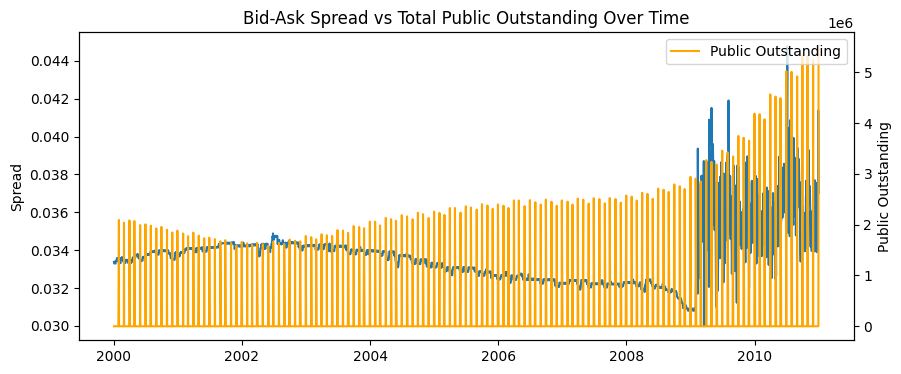

In [8]:

# 4. Basic sanity checks

print("Number of unique issues (crspid):", df["crspid"].nunique())
print("Date range:", df["qdate"].min(), "to", df["qdate"].max())

print("Summary of yield, bid-ask spread, and debt outstanding:")
df["mid_price"] = (df["bid"] + df["ask"]) / 2
df["bid_ask_spread"] = df["ask"] - df["bid"]
display(df[["yield", "bid_ask_spread", "totout", "pubout"]].describe())

# 5. Time series of average spread vs total public debt

agg = (
    df.groupby("qdate")
      .agg({
          "bid_ask_spread": "mean",
          "pubout": "sum"
      })
      .reset_index()
)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(agg["qdate"], agg["bid_ask_spread"], label="Avg B/A Spread")
plt.ylabel("Spread")
ax2 = plt.twinx()
ax2.plot(agg["qdate"], agg["pubout"], color="orange", label="Public Outstanding")
ax2.set_ylabel("Public Outstanding")
plt.title("Bid-Ask Spread vs Total Public Outstanding Over Time")
ax2.legend(loc="upper left")
plt.legend(loc="upper right")
plt.show()


In [9]:

# 6. Cross-sectional trade-off: does larger issue size (pubout) relate to tighter spread?
sub = df.dropna(subset=["bid_ask_spread", "pubout"])
sub2 = sub[sub["pubout"] > 0]
sub2["inv_pubout"] = 1.0 / sub2["pubout"]
corr = sub2[["bid_ask_spread", "inv_pubout"]].corr().iloc[0,1]
print("Corr(bid-ask spread, 1/pubout):", corr)

Corr(bid-ask spread, 1/pubout): 0.04449535517744245


C:\Users\Owner\AppData\Local\Temp\ipykernel_4364\1687187070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub2["inv_pubout"] = 1.0 / sub2["pubout"]


# PERSIST full sample data 


In [10]:
# --- Cell: setup imports & path config ---
import pandas as pd
from pathlib import Path
import sys
# ensure project root in path
sys.path.append(str(Path().resolve()))

from wrds_discovery import list_crsp_treasury_tables, preview_columns
from data_pull.crsp_treasury_pull import pull_bmquotes, pull_bmyield, pull_header, pull_debt_outstanding
from data_pull.build_crsp_features import build_crsp_panel

# define where to save outputs
DATA_DIR = Path("data")  # or your configured path
DATA_DIR.mkdir(parents=True, exist_ok=True)
PANEL_PARQUET = DATA_DIR / "crsp_treasury_panel.parquet"
PANEL_CSV = DATA_DIR / "crsp_treasury_panel.csv"

# --- Cell: list and inspect tables ---
tbls = list_crsp_treasury_tables()
print("Available CRSP Treasury tables:")
display(tbls.head(20))

for name in ["crsp.bmquotes", "crsp.bmyield", "crsp_a_treasuries.bmdebt", "crsp_a_treasuries.bmheader"]:
    print("--- Table:", name)
    cols, peek = preview_columns(name, n=3)
    print("Columns:", cols)
    display(peek)


Loading library list...
Done
Available CRSP Treasury tables:


,table
0,crsp.bmquotes
1,crsp.bmyield
2,crsp_a_treasuries.bmdebt
3,crsp_a_treasuries.bmheader
4,crsp_a_treasuries.bmpaymts
5,crsp_a_treasuries.bmquotes
6,crsp_a_treasuries.bmyield
7,crsp_a_treasuries.bndprt06
8,crsp_a_treasuries.bndprt12
9,crsp_a_treasuries.bxcalind


--- Table: crsp.bmquotes
Loading library list...
Done
Columns: ['crspid', 'qdate', 'bid', 'ask', 'source']


,crspid,qdate,bid,ask,source
0,19610622.800000,1961-06-14,99.956667,99.961111,R
1,19610622.800000,1961-06-15,99.963056,99.966944,R
2,19610622.800000,1961-06-16,99.965833,99.971667,R


--- Table: crsp.bmyield
Loading library list...
Done
Columns: ['crspid', 'qdate', 'accint', 'yield', 'retnua', 'duratn']


,crspid,qdate,accint,yield,retnua,duratn
0,19610622.800000,1961-06-14,0.000000,0.00005,-99.0000,8.0
1,19610622.800000,1961-06-15,0.000000,0.00005,0.0001,7.0
2,19610622.800000,1961-06-16,0.000000,0.00005,0.0000,6.0


--- Table: crsp_a_treasuries.bmdebt
Loading library list...
Done
Columns: ['crspid', 'qdate', 'totout', 'pubout']


,crspid,qdate,totout,pubout
0,19610706.400000,1961-06-30,1600,-99
1,19610713.400000,1961-06-30,1600,-99
2,19610715.400000,1961-06-30,1500,-99


--- Table: crsp_a_treasuries.bmheader
Loading library list...
Done
Columns: ['crspid', 'cusip', 'name', 'matdt', 'type', 'couprt', 'uniq', 'why', 'datdt', 'bankdt', 'fcaldt', 'ymcnot', 'notice', 'tax', 'flower', 'nippy', 'fcpdt', 'fcpdtf', 'valfc', 'numdbt', 'numpay', 'fstquo', 'lstquo', 'fstyld', 'lstyld']


,crspid,cusip,name,matdt,type,couprt,uniq,why,datdt,bankdt,...,nippy,fcpdt,fcpdtf,valfc,numdbt,numpay,fstquo,lstquo,fstyld,lstyld
0,19610622.800000,0XX,T_A_BILL,1961-06-22,8,0.000,0,1,1960-12-21,None,...,0,None,0,None,0,0,1,5,1,5
1,19610623.400000,0XX,BILL,1961-06-23,4,0.000,0,1,1960-12-22,None,...,0,None,0,None,0,0,1,6,1,6
2,19610629.400000,0XX,BILL,1961-06-29,4,0.000,0,1,1960-12-28,None,...,0,None,0,None,0,0,1,10,1,10


In [11]:

# --- Cell: pull & save full panel ---
print("Pulling full CRSP Treasury panel (quotes + yields + header + debt)...")
df_panel = build_crsp_panel(start_date="1980-01-01", end_date="2025-12-31")
print("Panel shape:", df_panel.shape)
display(df_panel.head())


Pulling full CRSP Treasury panel (quotes + yields + header + debt)...
Loading library list...
Done
Loading library list...
Done
Loading library list...
Done
Loading library list...
Done
Panel shape: (1917064, 35)


,crspid,qdate,bid,ask,source,accint,yield,retnua,duratn,cusip,...,fcpdtf,valfc,numdbt,numpay,fstquo,lstquo,fstyld,lstyld,totout,pubout
0,19800108.400000,1980-01-02,99.820167,99.834167,R,0.0,0.00029,0.0002,6.0,9127933C,...,0,None,12,0,4377,4625,4377,4625,NaN,NaN
1,19800108.400000,1980-01-03,99.848889,99.859861,R,0.0,0.00029,0.0003,5.0,9127933C,...,0,None,12,0,4377,4625,4377,4625,NaN,NaN
2,19800108.400000,1980-01-04,99.879778,99.887556,R,0.0,0.00029,0.0003,4.0,9127933C,...,0,None,12,0,4377,4625,4377,4625,NaN,NaN
3,19800110.400000,1980-01-02,99.758889,99.778889,R,0.0,0.00029,0.0001,8.0,9127933L,...,0,None,6,0,4504,4627,4504,4627,NaN,NaN
4,19800110.400000,1980-01-03,99.782806,99.803806,R,0.0,0.00030,0.0002,7.0,9127933L,...,0,None,6,0,4504,4627,4504,4627,NaN,NaN


In [12]:

print("Saving to parquet / CSV...")
df_panel.to_parquet(PANEL_PARQUET)
df_panel.to_csv(PANEL_CSV, index=False)
print("Saved to", PANEL_PARQUET, "and", PANEL_CSV)


Saving to parquet / CSV...
Saved to data\crsp_treasury_panel.parquet and data\crsp_treasury_panel.csv


In [13]:

# --- Cell: validation & summary metrics ---
print("Unique issues (crspid):", df_panel["crspid"].nunique())
print("Date range:", df_panel["qdate"].min(), "to", df_panel["qdate"].max())


Unique issues (crspid): 3335
Date range: 1980-01-02 00:00:00 to 2014-12-31 00:00:00


In [14]:

# compute mid price and bid-ask spread
df_panel["mid_price"] = (df_panel["bid"] + df_panel["ask"]) / 2
df_panel["bid_ask_spread"] = df_panel["ask"] - df_panel["bid"]

print("Summary stats for yield, spread, pubout:")
display(df_panel[["yield", "bid_ask_spread", "totout", "pubout"]].describe())


Summary stats for yield, spread, pubout:


,yield,bid_ask_spread,totout,pubout
count,1.917064e+06,1.917064e+06,91972.000000,91972.000000
mean,-2.951281e-03,8.928635e-02,16553.249119,10742.119373
std,5.538428e-01,1.361664e-01,14524.686020,10613.154318
min,-9.900000e+01,0.000000e+00,-99.000000,-99.000000
25%,8.000000e-05,3.125000e-02,6757.000000,2412.000000
50%,1.500000e-04,6.250000e-02,12348.000000,8509.000000
75%,2.100000e-04,1.250000e-01,22919.750000,15477.000000
max,6.560000e-03,1.070889e+00,179934.000000,74200.000000


In [15]:

# --- Cell: an aggregate series for time-series control inputs ---
agg = (
    df_panel.groupby("qdate")
      .agg({
          "bid_ask_spread": "mean",
          "pubout": "sum",
          "crspid": "nunique"
      })
      .rename(columns={"crspid": "n_issues"})
      .reset_index()
)
agg_path = DATA_DIR / "crsp_treasury_agg.csv"
agg.to_csv(agg_path, index=False)
print("Aggregate time-series saved to", agg_path)
display(agg.head())


Aggregate time-series saved to data\crsp_treasury_agg.csv


,qdate,bid_ask_spread,pubout,n_issues
0,1980-01-02,0.281055,0.0,154
1,1980-01-03,0.281311,0.0,154
2,1980-01-04,0.278968,0.0,156
3,1980-01-07,0.280139,0.0,155
4,1980-01-08,0.277723,0.0,156


In [ ]:
# --- Cell: Load CRSP datasets ---
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data")
panel = pd.read_parquet(DATA_DIR / "crsp_treasury_panel.parquet")
agg = pd.read_csv(DATA_DIR / "crsp_treasury_agg.csv", parse_dates=["qdate"])

print("Panel shape:", panel.shape)
print("Aggregate shape:", agg.shape)
display(panel.head())

# Before grouping:
print("Columns in panel:", panel.columns.tolist())

# Create mid_price / spread only if bid & ask exist
if ("bid" in panel.columns) and ("ask" in panel.columns):
    panel["mid_price"] = (panel["bid"] + panel["ask"]) / 2
    panel["bid_ask_spread"] = panel["ask"] - panel["bid"]
else:
    print("Warning: 'bid' or 'ask' missing; cannot compute bid_ask_spread")

# Calculate years to maturity & tenor bins as before
panel["years_to_maturity"] = (
    pd.to_datetime(panel["matdt"]) - pd.to_datetime(panel["qdate"])
).dt.days / 365
tenor_bins = [0, 2, 5, 10, 20, 30, 100]  # adjust upper bound
labels = ["0-2y", "2-5y", "5-10y", "10-20y", "20-30y", "30y+"]
panel["tenor_bucket"] = pd.cut(panel["years_to_maturity"], bins=tenor_bins, labels=labels)



Panel shape: (1917064, 35)
Aggregate shape: (8743, 4)


,crspid,qdate,bid,ask,source,accint,yield,retnua,duratn,cusip,...,fcpdtf,valfc,numdbt,numpay,fstquo,lstquo,fstyld,lstyld,totout,pubout
0,19800108.400000,1980-01-02,99.820167,99.834167,R,0.0,0.00029,0.0002,6.0,9127933C,...,0,None,12,0,4377,4625,4377,4625,NaN,NaN
1,19800108.400000,1980-01-03,99.848889,99.859861,R,0.0,0.00029,0.0003,5.0,9127933C,...,0,None,12,0,4377,4625,4377,4625,NaN,NaN
2,19800108.400000,1980-01-04,99.879778,99.887556,R,0.0,0.00029,0.0003,4.0,9127933C,...,0,None,12,0,4377,4625,4377,4625,NaN,NaN
3,19800110.400000,1980-01-02,99.758889,99.778889,R,0.0,0.00029,0.0001,8.0,9127933L,...,0,None,6,0,4504,4627,4504,4627,NaN,NaN
4,19800110.400000,1980-01-03,99.782806,99.803806,R,0.0,0.00030,0.0002,7.0,9127933L,...,0,None,6,0,4504,4627,4504,4627,NaN,NaN


Columns in panel: ['crspid', 'qdate', 'bid', 'ask', 'source', 'accint', 'yield', 'retnua', 'duratn', 'cusip', 'name', 'matdt', 'type', 'couprt', 'uniq', 'why', 'datdt', 'bankdt', 'fcaldt', 'ymcnot', 'notice', 'tax', 'flower', 'nippy', 'fcpdt', 'fcpdtf', 'valfc', 'numdbt', 'numpay', 'fstquo', 'lstquo', 'fstyld', 'lstyld', 'totout', 'pubout']


In [19]:
# Ensure grouping keys not categorical
panel["tenor_bucket"] = panel["tenor_bucket"].astype(str)
panel["qdate"] = pd.to_datetime(panel["qdate"])

# Compute mid/ spread if possible
if "bid" in panel.columns and "ask" in panel.columns:
    panel["bid_ask_spread"] = panel["ask"] - panel["bid"]

# Build agg dict
agg_dict = {}
if "bid_ask_spread" in panel.columns:
    agg_dict["bid_ask_spread"] = "mean"
if "pubout" in panel.columns:
    agg_dict["pubout"] = "sum"
if "crspid" in panel.columns:
    agg_dict["crspid"] = "nunique"

if not agg_dict:
    raise RuntimeError("No valid columns to aggregate")

# Use as_index=True + reset_index
tenor_liq = (
    panel.groupby(["qdate", "tenor_bucket"], as_index=True)
         .agg(agg_dict)
         .reset_index()
)
# Rename crspid -> n_issues if present
if "crspid" in agg_dict:
    tenor_liq = tenor_liq.rename(columns={"crspid": "n_issues"})

# Compute liquidity HHI
tenor_liq["liq_hhi"] = tenor_liq.groupby("qdate")["pubout"].transform(
    lambda x: (x**2).sum() / (x.sum() ** 2) if x.sum() > 0 else float("nan")
)

print("tenor_liq columns:", tenor_liq.columns.tolist())
display(tenor_liq.head())


tenor_liq columns: ['qdate', 'tenor_bucket', 'bid_ask_spread', 'pubout', 'n_issues', 'liq_hhi']


,qdate,tenor_bucket,bid_ask_spread,pubout,n_issues,liq_hhi
0,1980-01-02,0-2y,0.150087,0.0,86,NaN
1,1980-01-02,10-20y,0.777778,0.0,18,NaN
2,1980-01-02,2-5y,0.310096,0.0,26,NaN
3,1980-01-02,20-30y,0.281250,0.0,10,NaN
4,1980-01-02,5-10y,0.392857,0.0,14,NaN


In [20]:
DATA_DIR = Path("data")  # or your configured data folder
DATA_DIR.mkdir(parents=True, exist_ok=True)

TENOR_LIQ_PARQ = DATA_DIR / "tenor_liq.parquet"
TENOR_LIQ_CSV = DATA_DIR / "tenor_liq.csv"

print("Saving tenor_liq: shape =", tenor_liq.shape)

# Save parquet (efficient, preserves dtypes)
tenor_liq.to_parquet(TENOR_LIQ_PARQ, index=False)

# Also save CSV (for compatibility)
tenor_liq.to_csv(TENOR_LIQ_CSV, index=False)

print("Saved tenor_liq to:", TENOR_LIQ_PARQ, "and", TENOR_LIQ_CSV)

Saving tenor_liq: shape = (44408, 6)
Saved tenor_liq to: data\tenor_liq.parquet and data\tenor_liq.csv
